
KeyboardInterrupt



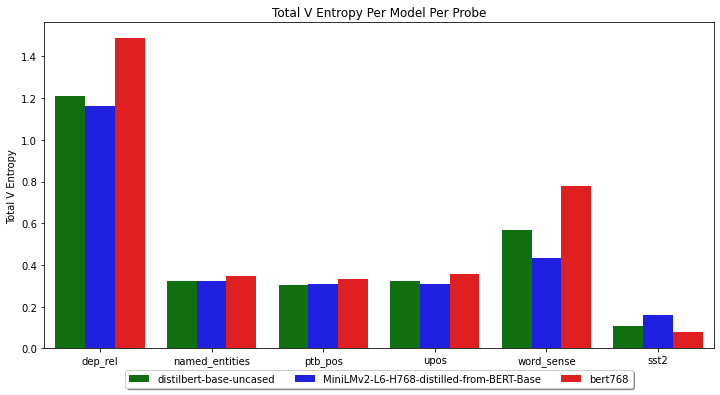

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

# bar ands lines are models
# y axis = infomration gain
# x axis = bar chart probes
# scatter = performance of glue task (y = axis glue acc, x axis = glue tasks)
#distilbert-base-uncased","MiniLMv2-L6-H768-distilled-from-BERT-Base and bert768

glue_tasks = ["qnli","mrpc","rte","cola","mnli","qqp","stsb","sst2"]
probe_tasks=["dep_rel","named_entities","ptb_pos","upos","word_sense","sst2"]
models = ["distilbert-base-uncased","MiniLMv2-L6-H768-distilled-from-BERT-Base","bert768"]
layer_numbers=[6,6,12]


# def get_total_probe_v_entropy(task,model_name,layer_number):
#     file_paths = ['reports/{}-{}-layer{}-{}.yaml.results/dev.v_entropy'.format(task,model_name,i,i+1) for i in range(0,layer_number)] 
#     total_acc = []
#     for file_path in file_paths: 
#         if os.path.isfile(file_path):
#             with open(file_path, "r") as f:
#                 total_acc.append(float(f.read().strip()))
#         else:
#             print("Path Invalid" + file_path)
#     return sum(total_acc)

def final_acc(task,model_name,layer_number):
    file_path = 'reports/{}-{}-layer{}.yaml.results/dev.label_acc'.format(task,model_name,layer_number) 
    if os.path.isfile(file_path):
        with open(file_path, "r") as f:
            return float(f.read().strip())
    else:
        print("Path Invalid" + file_path)



def get_total_probe_v_entropy(task,model_name,layer_number):
    single_layers = ['reports/{}-{}-layer{}.yaml.results/dev.v_entropy'.format(task,model_name,i) for i in range(0,layer_number)] #(0-5)
    two_layers = ['reports/{}-{}-layer{}-{}.yaml.results/dev.v_entropy'.format(task,model_name,i,i+1) for i in range(0,layer_number)] #(0-1),(1,2)
    base = []
    cond = []
    for file_path in single_layers:
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                base.append(float(f.read().strip()))
        else:
            print("Path Invalid")

    for two_layer_file_path in two_layers:
        if os.path.isfile(two_layer_file_path):
            with open(two_layer_file_path, "r") as f:
                cond.append(float(f.read().strip()))
        else:
            print("Path Invalid")
    r = [(b-c) for b, c in zip(base, cond)]
    return sum(r)

def get_glue_acc(glue_task,model_name,glue_data):
    model_condtion = glue_data["Model"] == model_name
    task_condtion = glue_data["Glue Task"] == glue_task
    return glue_data.loc[(model_condtion & task_condtion)]["Results"].iat[0]

df = pd.DataFrame(columns = ['Probe Task','Models','Total V Entropy'])
for count, model in enumerate(models):
    for probe_task in probe_tasks:
        total_v_entropy = get_total_probe_v_entropy(probe_task, model,layer_numbers[count])
        df.loc[len(df)] = [probe_task, model, total_v_entropy]

plt.figure(figsize=(12,6))
plt.title("Total V Entropy Per Model Per Probe")
sns.barplot(data=df, x='Probe Task', y='Total V Entropy', hue='Models',palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.savefig('graphs/Total V Entropy Per Model Per Probe.png', dpi=200)
plt.show()
plt.clf()

df_acc = pd.DataFrame(columns = ['Probe Task','Models','Final Layer Acc'])
for count, model in enumerate(models):
    for probe_task in probe_tasks:
        acc = final_acc(probe_task, model,layer_numbers[count])
        df_acc.loc[len(df_acc)] = [probe_task, model, acc]

plt.figure(figsize=(12,6))
plt.title("Final Layer Accuracy Per Model Per Probe")
plt.ylim(0.6, 1)
sns.barplot(data=df_acc, x='Probe Task', y='Final Layer Acc', hue='Models',palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.savefig('graphs/Final Layer Accuracy Per Model Per Probe.png', dpi=200)
plt.show()
plt.clf()

glue_data = pd.read_excel("grouped_data.xlsx")
glue_data_trimmed = glue_data.loc[glue_data['Model'].isin(models)]

plt.figure(figsize=(12,6))
plt.title("Glue Task Results")
plt.ylim(40, 100)
sns.barplot(data=glue_data_trimmed, x="Glue Task", y="Results", hue="Model", palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.savefig('graphs/Glue Task Results.png', dpi=200)
plt.show()
plt.clf()

In [8]:
import numpy as np
import os
import pandas as pd

def get_glue_acc(glue_task,model_name,glue_data):
    model_condtion = glue_data["Model"] == model_name
    task_condtion = glue_data["Glue Task"] == glue_task
    return glue_data.loc[(model_condtion & task_condtion)]["Results"].iat[0]

def pearson_correlation_get_y(models, layer, probe_task, entropy=False):

    file_paths = []
    for model in models:
        if model == "bert768":
            layer = layer * 2
        if entropy:
            file_paths.append('reports/{}-{}-layer{}.yaml.results/dev.v_entropy'.format(probe_task,model,layer))
        else:
            file_paths.append('reports/{}-{}-layer{}.yaml.results/dev.label_acc'.format(probe_task,model,layer))

    y = []
    for file_path in file_paths:
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                y.append(float(f.read().strip()))
        else:
            print("Path Invalid: " + file_path)
    return y

def pearson_correlation_get_x(models, glue_task, glue_data):
    x = []
    for model in models: 
        x.append(get_glue_acc(glue_task, model, glue_data))
    return x

def pearson_correlation_get_final_glue(model, glue_data):
    x = []
    all_glue_tasks = ["qnli","mrpc","rte","cola","mnli","qqp","stsb","sst2"]
    for glue_task in all_glue_tasks: 
        x.append(get_glue_acc(glue_task, model, glue_data))
    return sum(x)/len(x)

def pearson_correlation(x,y):
    return np.corrcoef(x, y)[0,1]  

#Layer x Probe x
def layerX_probeX(models, glue_tasks, glue_data, probe_tasks, entropy):
    for layer in range(7):
        for probe_task in probe_tasks:
            for glue_task in glue_tasks:
                x = pearson_correlation_get_x(models, glue_task, glue_data)
                y = pearson_correlation_get_y(models,layer, probe_task, entropy)
                corr = pearson_correlation(x,y)
                df.loc[len(df)] = [layer, probe_task, glue_task, corr]
                print(f"Layer: %s, Probe Task: %s, Glue Task: %s --- Correlation: %s" %(layer, probe_task, glue_task, corr))

# #Layer AVG Probe x
def layerAVG_probeX(models, glue_tasks, glue_data, probe_tasks, entropy):
    for probe_task in probe_tasks:
        for glue_task in glue_tasks:
            x = pearson_correlation_get_x(models, glue_task, glue_data)
            all_y = []
            for layer in range(7):
                all_y.append(pearson_correlation_get_y(models,layer, probe_task,entropy))
            y = np.sum(all_y, axis=0)/len(all_y)
            corr = pearson_correlation(x,y)
            df.loc[len(df)] = ["AVG", probe_task, glue_task, corr]
            print(f"Layer: AVG, Probe Task: %s, Glue Task: %s --- Correlation: %s" %(probe_task, glue_task, corr))

# #Layer x Probe AVG
def layerX_probeAVG(models, glue_tasks, glue_data, probe_tasks, entropy):
    for layer in range(7):
        for glue_task in glue_tasks:
            x = pearson_correlation_get_x(models, glue_task, glue_data)
            all_y = []
            for probe_task in probe_tasks:
                all_y.append(pearson_correlation_get_y(models,layer, probe_task, entropy))
            y = np.sum(all_y, axis=0)/len(all_y)
            corr = pearson_correlation(x,y)
            df.loc[len(df)] = [layer, "AVG", glue_task, corr]
            print(f"Layer: %s, Probe Task: AVG,  Glue Task: %s --- Correlation: %s" %(layer, glue_task, corr))

# #Layer AVG Probe AVG
def layerAVG_probeAVG(models, glue_tasks, glue_data, probe_tasks, entropy):
    for glue_task in glue_tasks:
        all_y = []
        for layer in range(7):
            for probe_task in probe_tasks:
                all_y.append(pearson_correlation_get_y(models,layer, probe_task, entropy))
        y = np.sum(all_y, axis=0)/len(all_y)
        x = pearson_correlation_get_x(models, glue_task, glue_data)
        corr = pearson_correlation(x,y)
        df.loc[len(df)] = ["AVG", "AVG", glue_task, corr]
        print(f"Layer: AVG, Probe Task: AVG, Glue Task: %s --- Correlation: %s" %(glue_task, corr))


# #Layer x Probe x Final Glue Score
def layerX_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, entropy):
    for layer in range(7):
        for probe_task in probe_tasks:
            x = []
            for model in models:
                x.append(pearson_correlation_get_final_glue(model, glue_data))
            y = pearson_correlation_get_y(models,layer, probe_task, entropy)
            corr = pearson_correlation(x,y)
            df.loc[len(df)] = [layer, probe_task, "Final Glue Score", corr]
            print(f"Layer: %s, Probe Task: %s, Glue Task: Final Glue Score --- Correlation: %s" %(layer, probe_task, corr))
            

# #Layer AVG Probe x Final Glue Score
def layerAVG_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, entropy):
    for probe_task in probe_tasks:
        x = []
        for model in models:
            x.append(pearson_correlation_get_final_glue(model, glue_data))
        all_y = []
        for layer in range(7):
            all_y.append(pearson_correlation_get_y(models,layer, probe_task, entropy))
        y = np.sum(all_y, axis=0)/len(all_y)
        corr = pearson_correlation(x,y)
        df.loc[len(df)] = ["AVG", probe_task, "Final Glue Score", corr]
        print(f"Layer: AVG, Probe Task: %s, Glue Task: Final Glue Score  --- Correlation: %s" %(probe_task,corr))

# #Layer x Probe AVG Final Glue Score
def layerX_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, entropy):
    for layer in range(7):
        x = []
        for model in models:
            x.append(pearson_correlation_get_final_glue(model, glue_data))
        all_y = []
        for probe_task in probe_tasks:
            all_y.append(pearson_correlation_get_y(models,layer, probe_task, entropy))
        y = np.sum(all_y, axis=0)/len(all_y)
        corr = pearson_correlation(x,y)
        df.loc[len(df)] = [layer, "AVG", "Final Glue Score", corr]
        print(f"Layer: %s, Probe Task: AVG,  Glue Task: Final Glue Score --- Correlation: %s" %(layer, corr))

# #Layer AVG Probe AVG Final Glue Score
def layerAVG_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, entropy):
    all_y = []
    for layer in range(7):
        for probe_task in probe_tasks:
            all_y.append(pearson_correlation_get_y(models,layer, probe_task, entropy))
    y = np.sum(all_y, axis=0)/len(all_y)
    x = []
    for model in models:
        x.append(pearson_correlation_get_final_glue(model, glue_data))
    corr = pearson_correlation(x,y)
    df.loc[len(df)] = ["AVG", "AVG", "Final Glue Score", corr]
    print(f"Layer: AVG, Probe Task: AVG, Glue Task: Final Glue Score --- Correlation: %s" %(corr))


models = ["distilbert-base-uncased","MiniLMv2-L6-H768-distilled-from-BERT-Base", "bert768"]
glue_data = pd.read_excel("grouped_data.xlsx")
glue_data_trimmed = glue_data.loc[glue_data['Model'].isin(models)]

glue_tasks = ["cola","mnli"]
probe_tasks=["dep_rel","named_entities","ptb_pos","upos","word_sense","sst2"]


df = pd.DataFrame(columns=['Layer','Probe Task','Glue Task','Accuracy Pearson Correlation'])

layerX_probeX(models, glue_tasks, glue_data, probe_tasks, False)
layerAVG_probeX(models, glue_tasks, glue_data, probe_tasks, False)
layerX_probeAVG(models, glue_tasks, glue_data, probe_tasks, False)
layerAVG_probeAVG(models, glue_tasks, glue_data, probe_tasks, False)
layerX_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, False)
layerAVG_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, False)
layerX_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, False)
layerAVG_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, False)

df_acc = df['Accuracy Pearson Correlation']


df = pd.DataFrame(columns=['Layer','Probe Task','Glue Task',' V-Entropy Pearson Correlation'])

layerX_probeX(models, glue_tasks, glue_data, probe_tasks, True)
layerAVG_probeX(models, glue_tasks, glue_data, probe_tasks, True)
layerX_probeAVG(models, glue_tasks, glue_data, probe_tasks, True)
layerAVG_probeAVG(models, glue_tasks, glue_data, probe_tasks, True)
layerX_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, True)
layerAVG_probeX_FGS(models, glue_tasks, glue_data, probe_tasks, True)
layerX_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, True)
layerAVG_probeAVG_FGS(models, glue_tasks, glue_data, probe_tasks, True)

df = df.join(df_acc)

df.to_csv("correlation.csv", float_format = "%.6f", index=False)

Layer: 0, Probe Task: dep_rel, Glue Task: cola --- Correlation: 0.7722770906935627
Layer: 0, Probe Task: dep_rel, Glue Task: mnli --- Correlation: 0.38543224481403476
Layer: 0, Probe Task: named_entities, Glue Task: cola --- Correlation: -0.45557575416084
Layer: 0, Probe Task: named_entities, Glue Task: mnli --- Correlation: -0.7208826772367365
Layer: 0, Probe Task: ptb_pos, Glue Task: cola --- Correlation: -0.9969854118426058
Layer: 0, Probe Task: ptb_pos, Glue Task: mnli --- Correlation: 0.21338170171589524
Layer: 0, Probe Task: upos, Glue Task: cola --- Correlation: -0.8543040275087264
Layer: 0, Probe Task: upos, Glue Task: mnli --- Correlation: -0.2511649370315376
Layer: 0, Probe Task: word_sense, Glue Task: cola --- Correlation: 0.9777433067419473
Layer: 0, Probe Task: word_sense, Glue Task: mnli --- Correlation: -0.08123750644138653
Layer: 0, Probe Task: sst2, Glue Task: cola --- Correlation: 0.7714869607986423
Layer: 0, Probe Task: sst2, Glue Task: mnli --- Correlation: 0.386578